# Group 35 Python Code

## Data Collection

### Extracting PDF content from Minutes

In [41]:
#Necessary imports
import PyPDF2
import requests
import numpy as np, seaborn as sns, pandas as pd
import nltk, nltk.sentiment, sklearn
import collections
%matplotlib inline

In [42]:
#convert list to pd.series

#Preprocessing - tokenize and lower case pdf-strings
tokenizer = nltk.tokenize.TweetTokenizer()
def preprocessing(string):
    string = string.lower()
    string = tokenizer.tokenize(string)
    return string

#Apply positive/negative sets on pdf-string
#tok_doc1 = doc1_str.apply(preprocessing)

def count_dictionary(document_elem, dictionary):
    lst = []
    for word in document_elem:
        if (word in dictionary):
            lst.append(word)
    return len(lst)

In [43]:
#PDF extractor script. Creates a list separated per page.
def pdf_extractor(path):
    pdf_file = open(path, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    res1 = []
    for i in range(len(c)):
        page = read_pdf.getPage(i)
        page_content = page.extractText()
        res1.append(page_content)
    return res1


### Creating Sentiment Variable

In [47]:
#Create bag of words 

bow = 'https://github.com/MatPiq/SDS-Group-35/blob/master/Exam_Project/bow.xlsx'

pos_neg = pd.read_excel(bow, '1 FS Dictionary')

positive_cb = pos_neg.loc[pos_neg['Positive'] == 1.0]
positive_cb = set(positive_cb['Word'])
positive_cb

negative_cb = pos_neg.loc[pos_neg['Negative'] == 1.0]
negative_cb = set(negative_cb['Word'])
negative_cb

HTTPError: HTTP Error 404: Not Found

In [37]:
import os

#Sebastian file path
basedir = r'https://github.com/MatPiq/SDS-Group-35/tree/master/Exam_Project/Minutes_PDF'

def sentiment_analysis(pos, neg, file_path):
    pos_words = []
    neg_words = []
    average_tone = []
    i = 0
    error = []
    
    for fn in os.listdir(file_path):
        try:
            print('Now treating file: ' + fn + '\nIterate: ' + str(i))
            doc = pdf_extractor(file_path + '\\' + fn)
            doc = pd.Series([''.join(doc)])
            doc = doc.apply(preprocessing)

            pos_words.append(int(count_dictionary(doc[0], pos)))
            neg_words.append(int(count_dictionary(doc[0], neg)))
            average_tone.append((pos_words[i]-neg_words[i])/len(doc[0]))
            error.append(False)  
            
            i += 1
        
        except KeyError:
            error.append(True)
            pos_words.append(np.NaN)
            neg_words.append(np.NaN)
            average_tone.append(np.NaN)
            
            i += 1
            
        #date = re.findall(r'\d+', fn)
    df = pd.DataFrame(zip(pos_words, neg_words, average_tone, error))
    return df

sent_df = sentiment_analysis(positive_cb, negative_cb, basedir)


NameError: name 'positive_cb' is not defined

In [ ]:
sent_df.columns = ['Number of positive words', 'Number of negative words', 'Average tone ratio', 'Error in processing PDF']
#print(sent_df.loc[sent_df['Number of positive words'] == True])
len(list(filter(lambda x: x > 0, sent_df['Average tone ratio'])))
sent_df

In [ ]:
import os, re, pandas as pd, ast, datetime

#Mark file path:
path = 'https://github.com/MatPiq/SDS-Group-35/tree/master/Exam_Project/Minutes_PDF'

files = []
files2 = []

# r=root, d=directories, f = files
for r, d, f in os.walk(basedir):
    for file in f:
        if '.pdf' in file:
            files.append('20' + file[3:5] + "-" + file[5:7] + "-" + file[7:9])
            files2.append(file)

Final_list = {'Dato':files,'Filnavn':files2}

df_files = pd.DataFrame(Final_list)
df_files['date_time'] = pd.to_datetime(df_files['Dato'])
df_files['Date time announcement'] = pd.to_datetime(df_files['Dato']) + pd.DateOffset(days=1)
df_files

### Collecting Stockmarket data

In [20]:
path_omx = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/omx30.csv'
cols = ['date', 'closing value']
omx = pd.read_csv(path_omx, sep=';', names = cols)

In [21]:
#opening value column
omx['opening value'] = omx['closing value'].shift(-1)
omx['date'] = pd.to_datetime(omx['date'])


#Difference between opening and closing value
omx['dif abs'] = omx['opening value'] - omx['closing value']
omx['dif abs'] = (omx['opening value']-omx['closing value']) / omx['closing value']
omx = omx.iloc[::-1]

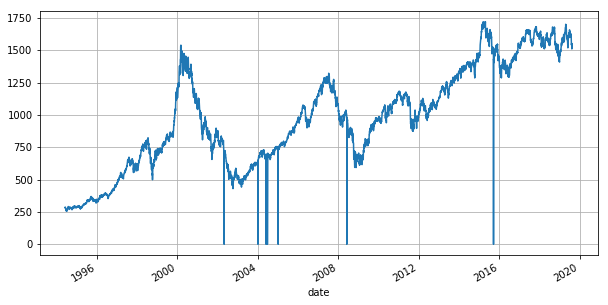

In [22]:
omx.plot('date', 'closing value', grid = True, legend = False, figsize=(10, 5))
plt.savefig('omx.png')

### Collecting Repo data

In [23]:

#import repo
path_repo = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/reporate.csv'
cols = ['date', 'repoann', 'repoeff']
repo = pd.read_csv(path_repo, sep=';', error_bad_lines=False, names = cols)
repo['date'] = pd.to_datetime(repo['date'])

In [24]:
#change in repo column
repo['repo_ch'] = repo['repoann']-repo['repoeff']

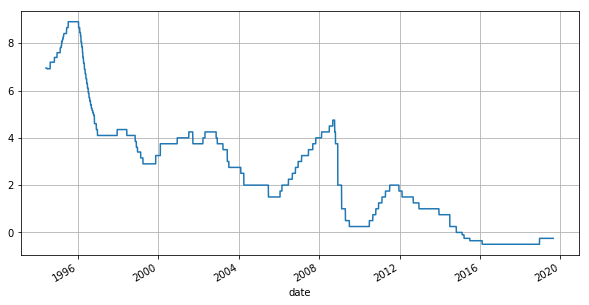

In [25]:
repo.plot('date', 'repoann', grid = True, legend = False, figsize=(10, 5))
plt.savefig('repo.png')

### Merging complete dataframe

In [13]:
#Necesary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
#Merge repo and omx
repo_omx = pd.merge(repo, omx, on = 'date', how = 'inner')


In [8]:
#Inspect and drop NaN
nan_rows = repo_omx[repo_omx.isnull().T.any().T]
repo_omx.dropna()
repo_omx.head()

,date,repoann,repoeff,repo_ch,closing value,opening value,dif abs,dif frac
0,1994-06-01,6.95,6.95,0.0,283.35,NaN,NaN,NaN
1,1994-06-02,6.95,6.95,0.0,282.32,283.35,1.03,0.003648
2,1994-06-03,6.95,6.95,0.0,284.12,282.32,-1.80,-0.006335
3,1994-06-06,6.95,6.95,0.0,286.71,284.12,-2.59,-0.009034
4,1994-06-07,6.95,6.95,0.0,282.07,286.71,4.64,0.016450


### Dataframe quality assorance and validation

## Sentiment analysis

### Model validation

## Machine learning Model

### Model validation